In [55]:
import numpy as np
import matplotlib.pyplot as plt 

import importlib

import components as comp
importlib.reload(comp);

import utils
importlib.reload(utils);

import tensorflow as tf
import tensorflow.experimental.numpy as tnp

tnp.experimental_enable_numpy_behavior()


I'm trying to use following parameters:  
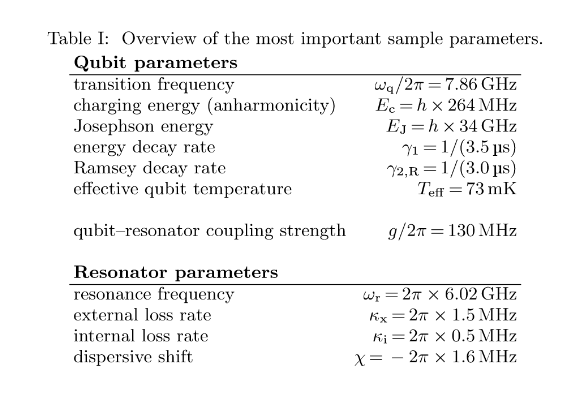

In [56]:
### Parameters
computational_states    = 2
resonator_states        = 20

# System
system = utils.System(dimensions = (resonator_states, computational_states))

# Define the components, which are defined in components.py
# The superconducting qubit
transmon = comp.Transmon(
    n_cutoff        = 11,
    e               = 1.519e6,              # GHz / V
    EJ              = 2 * np.pi * 34,       # GHz hbar
    EJ_EC_ratio     = 128,                  # Gives EC = EJ / ratio
    # gamma           = 2.5                 # EJ2 / EJ1    
)

# Resonator for readout
resonator = comp.Resonator(
    omega           = 2 * np.pi * 6.02,                 # GHz
    n_cutoff        = resonator_states      # States of harmonic oscillator
    
)

# Readout pulse # Jusst for testing - a seperate pulse is defined at every frequency
readout_pulse = comp.ResonatorProbePulse(
    omega       = 2 * np.pi * 6.02,
    duration    = (20, 30),
    rise_time   = 2,
    fall_time   = 2,
    amplitude   = 5 / 6.02 ** 2
)


## Defining Hamiltonians
We can now define the hamiltonians of the system, which sould be these:

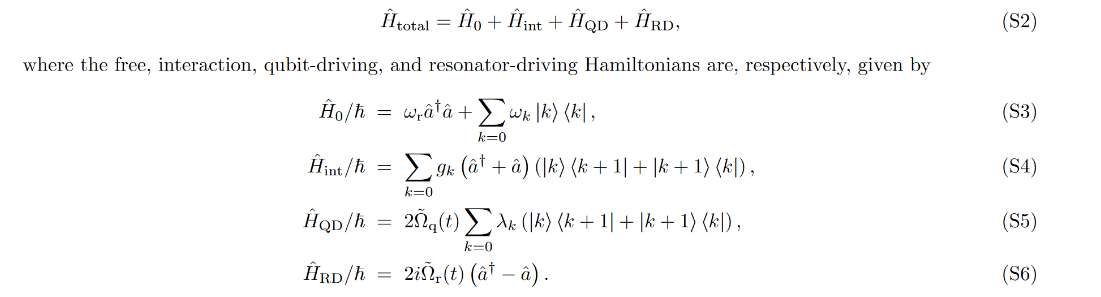

In [57]:
# Find subspace of Transmon
Es, Psis = transmon.eigen_basis(computational_states)   # Get states and energies for transmon
H0_transmon = np.diag(Es)                               # Set E0 = 0


# H0 of the resonator is simply found by:
H0_resonator    = resonator.Hamiltonian().todense()


# We need to define mathematical tools to combine the system
transmon_identity   = np.identity(n = computational_states)
resonator_identity  = np.identity(n = resonator_states)


# Combine the Hamiltonians by tensor product 
H0_transmon_big  = np.kron(resonator_identity,  H0_transmon)
H0_resonator_big = np.kron(H0_resonator,        transmon_identity)

# Sum to get full H0 in 3 x 20 space
H0 = H0_transmon_big + H0_resonator_big


[[-1.13255887e-15 -1.39106622e+00]
 [-1.39106622e+00 -4.69467146e-16]]


/tmp/ipykernel_466/3494836823.py:21: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(H_with_interaction))
/tmp/ipykernel_466/3494836823.py:21: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(H_with_interaction))


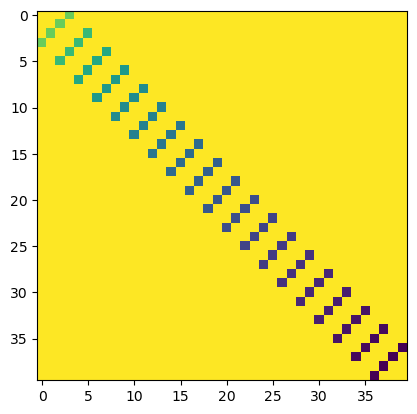

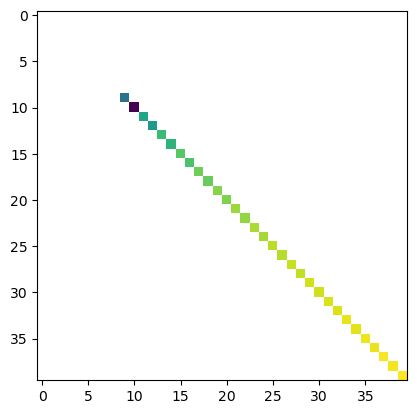

In [58]:
# Overlap
H_overlap_n = Psis.conj().T @ transmon.n_matrix() @ Psis

print(H_overlap_n)

# This is the rotating wave approximation.
# H_q_to_r = np.kron(resonator.a_dagger().todense(), np.triu(transmon_identity))
# H_r_to_q = np.kron(resonator.a().todense(),        np.tril(transmon_identity))
# H_int = H_q_to_r + H_r_to_q
# 

# This should be exact
H_int = np.kron((resonator.a_dagger() + resonator.a()).todense(), H_overlap_n)
plt.imshow(H_int)

plt.figure()
interaction_strength = 2 * np.pi * 0.130 # GHz / 2 pi  
# interaction_strength *= 1 

H_with_interaction = H0 + interaction_strength *  H_int
plt.imshow(np.log(H_with_interaction))

H_with_interaction = tf.convert_to_tensor(H_with_interaction, dtype = tf.complex128)

## Readout Drive

In [116]:
class tf_ResonatorProbePulse():
    """
    This class creates a pulse that can be used to probe the resonator.
    It is made by having a fast rise and fall time using a sin^2 envelope. Inbetween it is constant.
    """

    def __init__(self, duration, omega, rise_time = 1, fall_time = 1, amplitude = 1, phase = 0):
        self.duration   = duration
        self.rise_time  = rise_time
        self.fall_time  = fall_time
        self.amplitude  = amplitude
        self.phase      = phase
        self.omega      = omega

        # Find I and Q
        self.I      = tnp.cos(phase)
        self.Q      = tnp.sin(phase)

        # Envelopes:
        self.epsilon_I, self.epsilon_Q = self.envelopes()

        # Pulses
        self.I_pulse, self.Q_pulse = self.pulses()


    # Put together:
    def output(self):
        def I_pulse(t):
            I_comp = self.I * self.epsilon_I(t) * self.I_pulse(t)
            return I_comp
        
        def Q_pulse(t):
            Q_comp = self.Q * self.epsilon_Q(t) * self.Q_pulse(t)
            return Q_comp

        return I_pulse, Q_pulse

    # Get the pulses
    def pulses(self):
        I_pulse = lambda t: tnp.cos(self.omega * (t - self.duration[0]))
        Q_pulse = lambda t: tnp.sin(self.omega * (t - self.duration[0]))
        return I_pulse, Q_pulse

    # Compute the envelopes
    def envelopes(self):

        def epsilon_I(t):
            if t >= self.duration[0] and t < self.duration[0] + self.rise_time:
                return self.amplitude * tnp.sin((t - self.duration[0])/self.rise_time * tnp.pi / 2 ) ** 2 
            elif t >= self.duration[0] + self.rise_time and t < self.duration[1] - self.fall_time:
                return tnp.ones_like(t) * self.amplitude
            elif t >= self.duration[1] - self.fall_time and t < self.duration[1]:
                return self.amplitude * tnp.sin((t - self.duration[1])/self.fall_time * 2 / tnp.pi ) ** 2
            else:
                return tnp.zeros_like(t)

        epsilon_Q = epsilon_I

        return epsilon_I, epsilon_Q


In [117]:
resonator_a = tf.convert_to_tensor(resonator.a().todense(), dtype = tf.complex128)
resonator_a_dagger = tf.convert_to_tensor(resonator.a_dagger().todense(), dtype = tf.complex128)
resonator_n = tf.convert_to_tensor(resonator.n_matrix().todense(), dtype = tf.complex128)

def get_Hamiltonian(omega = 6.02 * 2 * np.pi):
    readout_pulse = tf_ResonatorProbePulse(
        omega       = omega,
        duration    = (0, 50),
        rise_time   = 0,
        fall_time   = 0,
        amplitude   = 1 / 10
    )

    # Get pulse and the Unitary transformation opposite to the pulse
    pulse_on_resonator = readout_pulse.output()
    
    def Hamiltonian(t):
        constant_H = H_with_interaction

        # Define the pules and hamiltonian interacting with the resonator
        total_pulse = pulse_on_resonator[0](t) + pulse_on_resonator[1](t) 
        H_reso      = 2j *  total_pulse * (resonator_a_dagger - resonator_a)
        H_reso_hilbert_space = tnp.kron(H_reso, transmon_identity)

        return constant_H + H_reso_hilbert_space

    return Hamiltonian

def get_unitary_transformation(omega = 6.02 * 2 * np.pi):
    # n matrix for resonator and k matrix for transmon
    n = tnp.kron(resonator_n, transmon_identity)
    k = tnp.kron(resonator_identity,             np.diag(np.arange(computational_states)))
    
    # Transformation
    def U(t):
        return tf.linalg.expm(1j * omega * (n + k) * t)

    # The time derivative of the transformation
    def U_dot(t):
        return 1j * omega * (n + k) @ U(t)

    return U, U_dot    

In [133]:
def get_master_equation(omega):
    # Get time-dependent elements
    H = get_Hamiltonian(omega)
    U, U_dot = get_unitary_transformation(omega)

    @tf.function()
    def master_equation(t, rho):
        # Compute matrices at time t
        H_t = H(t)
        U_t = U(t)
        U_dot_t = U_dot(t)

        # Compute the rotating frame
        H_rotating = U_t @ H_t @ tf.linalg.adjoint(U_t) + 1j * U_dot_t @ tf.linalg.adjoint(U_t)


        # Time derivative of the density matrix
        d_rho = -1j * (H_rotating @ rho - rho @ H_rotating)

        return d_rho
    
    return master_equation


In [134]:
# Define the first excited state of the resonator
resonator_g = np.zeros(resonator_states, dtype = np.complex128)
resonator_g[0] = 1

# Define ground state of transmon
transmon_g = np.array((1, 0), dtype = np.complex128)
transmon_e = np.array((0, 1), dtype = np.complex128)

# Define initial density matrix
initial_state_g = np.kron(resonator_g, transmon_g)
initial_density_matrix_g = np.outer(initial_state_g, initial_state_g.conj())

initial_state_e = np.kron(resonator_g, transmon_e)
initial_density_matrix_e = np.outer(initial_state_e, initial_state_e.conj())

In [131]:
initial_density_matrices = tf.convert_to_tensor([initial_density_matrix_g, initial_density_matrix_e], dtype = tf.complex128)

In [166]:
import tensorflow_probability as tfp

start_time = 0
final_time = 50
omega = 6.02 * 2 * np.pi

solution_times = tfp.math.ode.ChosenBySolver(final_time)

master_equation = get_master_equation(omega)

results = tfp.math.ode.DormandPrince(first_step_size = 1).solve(
    master_equation,
    initial_time = start_time,
    initial_state = initial_density_matrices,
    solution_times = solution_times
)

In [167]:
trace_photon_count = tnp.kron(resonator_n, transmon_identity)

states_g = results.states[:, 0]
states_e = results.states[:, 1]

photon_count_g = tnp.einsum('tii->t', trace_photon_count @ states_g)
photon_count_e = tnp.einsum('tii->t', trace_photon_count @ states_e)

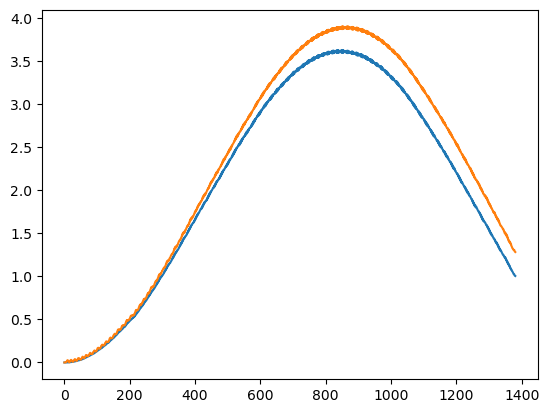

In [168]:
plt.plot(photon_count_g.numpy().real)
plt.plot(photon_count_e.numpy().real)

In [169]:
from scipy.special import factorial

def Q_function(density_matrix, n_cutoff = resonator_states, resolution = 20):
    xs = ys = np.linspace(-n_cutoff, n_cutoff, resolution)
    xs, ys = np.meshgrid(xs, ys)

    # Calculate alphas
    alphas = xs + 1j * ys
    alphas = alphas.flatten()

    # Noramlization
    normalization = np.exp(- alphas * alphas.conj() / 2)

    # Basis change
    ns = np.expand_dims(np.arange(n_cutoff), 1)
    P  = normalization * np.power(alphas, ns) / np.sqrt(factorial(ns))

    return np.einsum("tij, tjk, tkl -> til", P.conj().T, density_matrix, P).reshape((resolution, resolution))
    # np.diag(P.conj().T @ density_matrix @ P).reshape((resolution, resolution))


In [ ]:
Q_function()

In [ ]:
def plot_Q(time, frequency_choice = 0, resolution = 100):
    sol_e = results_e[frequency_choice].y.reshape(system.hilbert_size, system.hilbert_size, -1)
    sol_g = results_g[frequency_choice].y.reshape(system.hilbert_size, system.hilbert_size, -1)

    reso_e  = system.partial_trace(sol_e[:, :, time], 1)
    reso_g  = system.partial_trace(sol_g[:, :, time], 1)

    # Get the Q function
    Q_e = Q_function(reso_e, resolution=resolution, n_cutoff = resonator_states)
    Q_g = Q_function(reso_g, resolution=resolution, n_cutoff = resonator_states)

    # Plot the Q function
    plt.imshow(abs(Q_e), cmap = "Blues", alpha = .5)
    plt.imshow(abs(Q_g), cmap = "Reds", alpha = .5)

    plt.hlines(resolution / 2, 0, resolution, linestyles = "dashed", color = "black")
    plt.vlines(resolution / 2, 0, resolution, linestyles = "dashed", color = "black")

from ipywidgets import interact
interact(plot_Q, time = (0, results_g[0].y.shape[1] - 1, 1), frequency_choice = (0, len(omegas_to_test) - 1, 1))

interactive(children=(IntSlider(value=553, description='time', max=1107), IntSlider(value=0, description='freq…

<function __main__.plot_Q(time, frequency_choice=0, resolution=100)>

In [ ]:
dims = np.prod(system.dimensions)
def get_expectation_occupation(results):
    rhos = [ds.y.reshape(system.hilbert_size, system.hilbert_size, -1) for ds in results]
    last_rho = [rho[:, :, -1] for rho in rhos]
    last_rho_reso = [system.partial_trace(rho, trace_over = 1) for rho in last_rho]
    last_exp_n    = [np.trace(rho @ resonator.n_matrix()) for rho in last_rho_reso]

    return last_exp_n

exp_n_g = get_expectation_occupation(results_g)
exp_n_e = get_expectation_occupation(results_e)


/home/johannseverin/anaconda3/envs/qi/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


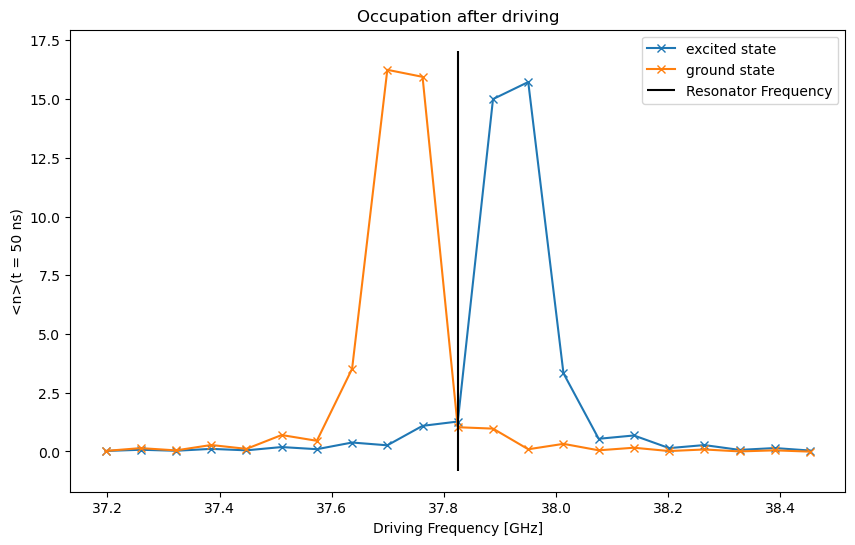

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

ax.plot(omegas_to_test, exp_n_e, marker = "x", label = "excited state")
ax.plot(omegas_to_test, exp_n_g, marker = "x", label = "ground state")

ax.vlines(2 * np.pi * 6.02, *ax.get_ylim(), color = "k", label = "Resonator Frequency")

ax.set(
    xlabel = "Driving Frequency [GHz]",
    ylabel = "<n>(t = 50 ns)",
    title = "Occupation after driving"
)

ax.legend()